In [ ]:
import tensorflow as tf

# List physical GPU devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}, Details: {details}")
else:
    print("No GPU found")


Device: /physical_device:GPU:0, Details: {'device_name': 'NVIDIA GeForce RTX 4050 Laptop GPU', 'compute_capability': (8, 9)}


In [ ]:

from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ---------------------------
# Step 1: Load and Prepare Data
# ---------------------------
data_path = 'list_merged_no_X_no_dups_cleaned_final.csv'
df = pd.read_csv(data_path)

display(Markdown("## Original Data Head"))
display(df.head())

# ---------------------------
# Step 2: Configuration and Mappings
# ---------------------------
vocab_size = 21  # 20 amino acids + padding
num_classes = 4  # 3 secondary structure classes + padding
max_seq_len = 512
embedding_dim = 512
dropout_rate = 0.6
l2_lambda = 0.01

# Mapping dictionaries
aa_dict = {aa: idx for idx, aa in enumerate('ACDEFGHIKLMNPQRSTVWY', 1)}
ss_dict = {'C': 1, 'H': 2, 'E': 3}  # 0 reserved for padding

display(Markdown("## Mappings"))
display(Markdown(f"**Amino Acid Dictionary:** {aa_dict}"))
display(Markdown(f"**Secondary Structure Dictionary:** {ss_dict}"))

# ---------------------------
# Step 3: Data Preprocessing
# ---------------------------
def process_sequence(row):
    aa_padded = row['input'].ljust(max_seq_len, '0')[:max_seq_len]
    ss_padded = row['dssp3'].ljust(max_seq_len, '0')[:max_seq_len]

    aa_encoded = [aa_dict.get(c, 0) for c in aa_padded]
    ss_encoded = [ss_dict.get(c, 0) for c in ss_padded]

    ss_one_hot = tf.keras.utils.to_categorical(ss_encoded, num_classes=num_classes)

    return aa_encoded, ss_one_hot

df['processed'] = df.apply(process_sequence, axis=1)

display(Markdown("## Data After Processing (First 5 Rows)"))
display(df[['input', 'dssp3', 'processed']].head())

# Extract sequences and labels
aa_sequences = np.array([x[0] for x in df['processed']])
ss_labels = np.array([x[1] for x in df['processed']])

display(Markdown("## Amino Acid Sequences Array (First 5 Entries)"))
display(aa_sequences[:5])
display(Markdown("## Secondary Structure Labels Array (First 5 Entries)"))
display(ss_labels[:5])

# ---------------------------
# Step 4: Train/Validation/Test Split
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(aa_sequences, ss_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.66, random_state=42)

display(Markdown("## Data Split Shapes"))
display(Markdown(f"**X_train shape:** {X_train.shape}"))
display(Markdown(f"**y_train shape:** {y_train.shape}"))
display(Markdown(f"**X_val shape:** {X_val.shape}"))
display(Markdown(f"**y_val shape:** {y_val.shape}"))
display(Markdown(f"**X_test shape:** {X_test.shape}"))
display(Markdown(f"**y_test shape:** {y_test.shape}"))

# ---------------------------
# Step 5: Custom Metrics and Callbacks
# ---------------------------
class LearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)
        super().on_epoch_end(epoch, logs)

def masked_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(tf.argmax(y_true, axis=-1), 0), tf.float32)
    return tf.reduce_sum(loss * mask) / tf.maximum(tf.reduce_sum(mask), 1)

def masked_accuracy(y_true, y_pred):
    y_true_class = tf.argmax(y_true, axis=-1)
    y_pred_class = tf.argmax(y_pred, axis=-1)
    mask = tf.cast(tf.not_equal(y_true_class, 0), tf.float32)
    matches = tf.cast(tf.equal(y_true_class, y_pred_class), tf.float32) * mask
    return tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)

checkpoint_callback = ModelCheckpoint(
    filepath='best_model_kernel_5.h5',         # Path where the model will be saved
    monitor='val_masked_accuracy',     # Metric to monitor
    mode='max',                        # We want to maximize the accuracy
    save_best_only=True,               # Only save if the metric improves
    verbose=1
)

# ---------------------------
# Step 6: Build the Model
# ---------------------------
model = Sequential([
    Input(shape=(max_seq_len,), dtype='int32'),
    Embedding(vocab_size, embedding_dim, mask_zero=True),
    Conv1D(512, 5, activation='relu', padding='same'),
    Conv1D(512, 5, activation='relu', padding='same'),
    Conv1D(512, 5, activation='relu', padding='same'),
    Bidirectional(LSTM(512, return_sequences=True, kernel_regularizer=l2(l2_lambda))),
    Dropout(dropout_rate),
    Bidirectional(GRU(512, return_sequences=True, kernel_regularizer=l2(l2_lambda))),
    Dropout(dropout_rate),
    TimeDistributed(Dense(128, activation='relu')),
    Dropout(dropout_rate),
    TimeDistributed(Dense(64, activation='relu')),
    Dropout(dropout_rate),
    TimeDistributed(Dense(num_classes, activation='softmax'))
])


## Original Data Head

,input,dssp3
0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...
1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEEEECCCCCCCCHHHH...
2,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...
3,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTAAKSELDKAIGR...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEECCHHHHHHHHHHCC...
4,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHCCCCCECEECCCCCEEECCCEEEECCCCCCHHHHHH...


## Mappings

**Amino Acid Dictionary:** {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

**Secondary Structure Dictionary:** {'C': 1, 'H': 2, 'E': 3}

## Data After Processing (First 5 Rows)

,input,dssp3,processed
0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,"([11, 18, 10, 16, 4, 6, 4, 19, 14, 10, 18, 10,..."
1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEEEECCCCCCCCHHHH...,"([11, 12, 8, 5, 4, 11, 10, 15, 8, 3, 4, 6, 10,..."
2,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,"([11, 18, 10, 16, 4, 6, 4, 19, 14, 10, 18, 10,..."
3,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTAAKSELDKAIGR...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEECCHHHHHHHHHHCC...,"([11, 12, 8, 5, 4, 11, 10, 15, 8, 3, 4, 6, 10,..."
4,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,CCHHHHHHHHCCCCCECEECCCCCEEECCCEEEECCCCCCHHHHHH...,"([11, 12, 8, 5, 4, 11, 10, 15, 8, 3, 4, 6, 10,..."


## Amino Acid Sequences Array (First 5 Entries)

array([[11, 18, 10, ...,  0,  0,  0],
       [11, 12,  8, ...,  0,  0,  0],
       [11, 18, 10, ...,  0,  0,  0],
       [11, 12,  8, ...,  0,  0,  0],
       [11, 12,  8, ...,  0,  0,  0]])

## Secondary Structure Labels Array (First 5 Entries)

array([[[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]], dtype=float32)

## Data Split Shapes

**X_train shape:** (87342, 512)

**y_train shape:** (87342, 512, 4)

**X_val shape:** (12727, 512)

**y_val shape:** (12727, 512, 4)

**X_test shape:** (24706, 512)

**y_test shape:** (24706, 512, 4)

In [ ]:

# ---------------------------
# Step 7: Compile the Model
# ---------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss=masked_categorical_crossentropy,
    metrics=[masked_accuracy]
)

model.summary()

# ---------------------------
# Step 8: Model Training
# ---------------------------
callbacks = [
    checkpoint_callback,
    LearningRateTracker(),
    EarlyStopping(monitor='loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32,
    callbacks=callbacks
)

# ---------------------------
# Step 9: Plot Training Metrics
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(history.history['lr'])
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['masked_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_masked_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Step 10: Evaluation Function
# ---------------------------

def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)

    # Convert one-hot encoded labels to class indices
    y_true_classes = np.argmax(y_test, axis=-1).flatten()
    y_pred_classes = np.argmax(y_pred, axis=-1).flatten()

    # Create mask to ignore padding (class 0)
    mask = y_true_classes != 0

    # Apply mask to both true and predicted labels
    y_true_masked = y_true_classes[mask]
    y_pred_masked = y_pred_classes[mask]

    # Calculate metrics
    accuracy = accuracy_score(y_true_masked, y_pred_masked)
    print(f"\nTest Accuracy (excluding padding): {accuracy:.4f}")

    # Classification report (C=1, H=2, E=3 in our encoding)
    print("\nClassification Report:")
    print(classification_report(
        y_true_masked,
        y_pred_masked,
        target_names=['C', 'H', 'E'],
        labels=[1, 2, 3],
        digits=4
    ))

    # Compute confusion matrix
    cm = confusion_matrix(y_true_masked, y_pred_masked, labels=[1, 2, 3])

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['C', 'H', 'E'],
                yticklabels=['C', 'H', 'E'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (excluding padding)')
    plt.show()

    # Compute normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['C', 'H', 'E'],
                yticklabels=['C', 'H', 'E'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix (excluding padding)')
    plt.show()


# ---------------------------
# Step 11: Evaluate the Model
# ---------------------------
evaluate_model(model, X_test, y_test)


# ---------------------------
# Step 12: Prediction Function
# ---------------------------
def predict_sequence(model, sequence):
    original_length = len(sequence)
    padded_sequence = sequence.ljust(max_seq_len, '0')[:max_seq_len]
    encoded_sequence = [aa_dict.get(c, 0) for c in padded_sequence]
    prediction = model.predict(np.array([encoded_sequence]))
    return np.argmax(prediction[0][:original_length], axis=-1)

# Example:
# predicted_classes = predict_sequence(model, 'ACDEFG')
# print("Predicted Secondary Structures:", predicted_classes)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 512)          10752     
                                                                 
 conv1d (Conv1D)             (None, 512, 512)          1311232   
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 512)          1311232   
                                                                 
 conv1d_2 (Conv1D)           (None, 512, 512)          1311232   
                                                                 
 bidirectional (Bidirectiona  (None, 512, 1024)        4198400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 1024)         0         
                                                        

Exception ignored in: <function UniquePtr.__del__ at 0x00000268F3138310>
Traceback (most recent call last):
  File "C:\Users\91810\anaconda3\envs\GPU\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
KeyboardInterrupt: 


KeyboardInterrupt: 

773/773 [==============================] - 134s 170ms/step

Test Accuracy (excluding padding): 0.8899

Classification Report:
              precision    recall  f1-score   support

           C     0.8727    0.8772    0.8749   3873895
           H     0.9054    0.9179    0.9116   3479109
           E     0.8958    0.8681    0.8817   2200142

    accuracy                         0.8899   9553146
   macro avg     0.8913    0.8877    0.8894   9553146
weighted avg     0.8899    0.8899    0.8899   9553146



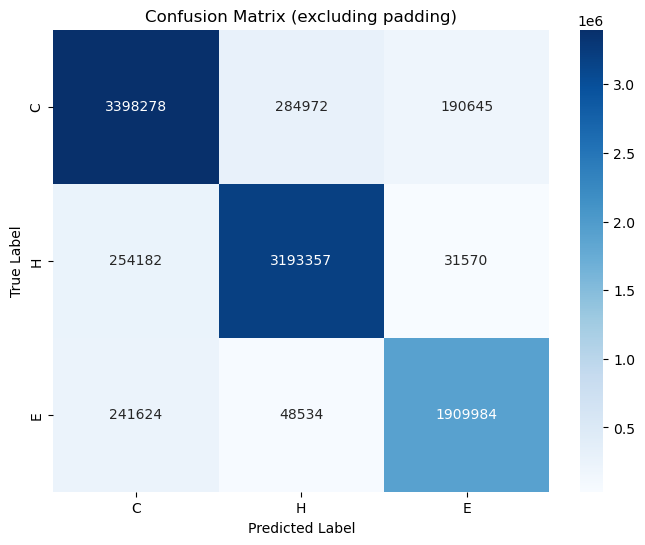

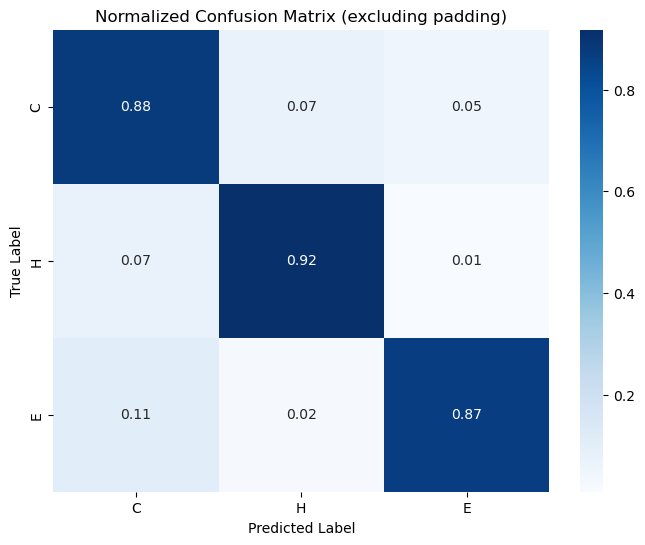

In [ ]:
# Load the best saved model with custom metrics and loss function
model = tf.keras.models.load_model(
    "best_model_kernel_5.h5",
    custom_objects={
        'masked_accuracy': masked_accuracy,
        'masked_categorical_crossentropy': masked_categorical_crossentropy
    }
)

# ---------------------------
# Step 10: Evaluation Function
# ---------------------------

def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)

    # Convert one-hot encoded labels to class indices
    y_true_classes = np.argmax(y_test, axis=-1).flatten()
    y_pred_classes = np.argmax(y_pred, axis=-1).flatten()

    # Create mask to ignore padding (class 0)
    mask = y_true_classes != 0

    # Apply mask to both true and predicted labels
    y_true_masked = y_true_classes[mask]
    y_pred_masked = y_pred_classes[mask]

    # Calculate metrics
    accuracy = accuracy_score(y_true_masked, y_pred_masked)
    print(f"\nTest Accuracy (excluding padding): {accuracy:.4f}")

    # Classification report (C=1, H=2, E=3 in our encoding)
    print("\nClassification Report:")
    print(classification_report(
        y_true_masked,
        y_pred_masked,
        target_names=['C', 'H', 'E'],
        labels=[1, 2, 3],
        digits=4
    ))

    # Compute confusion matrix
    cm = confusion_matrix(y_true_masked, y_pred_masked, labels=[1, 2, 3])

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['C', 'H', 'E'],
                yticklabels=['C', 'H', 'E'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (excluding padding)')
    plt.show()

    # Compute normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['C', 'H', 'E'],
                yticklabels=['C', 'H', 'E'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix (excluding padding)')
    plt.show()


# ---------------------------
# Step 11: Evaluate the Model
# ---------------------------
evaluate_model(model, X_test, y_test)


# ---------------------------
# Step 12: Prediction Function
# ---------------------------
def predict_sequence(model, sequence):
    original_length = len(sequence)
    padded_sequence = sequence.ljust(max_seq_len, '0')[:max_seq_len]
    encoded_sequence = [aa_dict.get(c, 0) for c in padded_sequence]
    prediction = model.predict(np.array([encoded_sequence]))
    return np.argmax(prediction[0][:original_length], axis=-1)

# Example:
# predicted_classes = predict_sequence(model, 'ACDEFG')
# print("Predicted Secondary Structures:", predicted_classes)
